In [1]:
import time

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
data_dir = "D:/github/archive/chest_xray/chest_xray"
batch_size = 32
image_size = 128  # or 256

# Transform with resizing and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}


In [4]:
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time

In [5]:
datasets_dict = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
                 for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(datasets_dict[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'val', 'test']}

class_names = datasets_dict['train'].classes

In [14]:
sample, label = datasets_dict['train'][1341]
print(sample.shape)

torch.Size([1, 128, 128])


In [15]:
print(label)

1


In [7]:
class CNN(nn.Module):
    def __init__(self, input_features):  # 1 for grayscale, 3 for RGB
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128 -> 64
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 -> 32

            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 -> 32

            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),  
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(64, 2)  # Assuming 2 classes: normal and pneumonia
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [8]:
torch.cuda.is_available()

True

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = CNN(input_features=1).to(device)  # move model to GPU


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
from torchinfo import summary

In [11]:
summary(model, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         320
│    └─ReLU: 2-2                         [1, 32, 128, 128]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 128, 128]         64
│    └─MaxPool2d: 2-4                    [1, 32, 64, 64]           --
│    └─Conv2d: 2-5                       [1, 64, 64, 64]           18,496
│    └─ReLU: 2-6                         [1, 64, 64, 64]           --
│    └─BatchNorm2d: 2-7                  [1, 64, 64, 64]           128
│    └─MaxPool2d: 2-8                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-10                        [1, 64, 32, 32]           --
│    └─BatchNorm2d: 2-11                 [1, 64, 32, 32]           128
│   

In [12]:
loss_train = []
acc_train = []
for epoch in range(30):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start = time.time()
    temp_loss = 0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        temp_loss = loss.detach().cpu().item()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    acc_train.append(acc)
    loss_train.append(temp_loss)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")
    print(f"Hey! the calculations are done in {_time(start, time.time())}")


Epoch 1, Loss: 35.6170, Accuracy: 92.06%
Hey! the calculations are done in 1min 43.86sec
Epoch 2, Loss: 17.2345, Accuracy: 96.17%
Hey! the calculations are done in 1min 0.93sec
Epoch 3, Loss: 13.8591, Accuracy: 96.70%
Hey! the calculations are done in 1min 0.36sec
Epoch 4, Loss: 11.6157, Accuracy: 97.58%
Hey! the calculations are done in 1min 0.16sec
Epoch 5, Loss: 8.8913, Accuracy: 98.06%
Hey! the calculations are done in 59.03sec
Epoch 6, Loss: 7.5229, Accuracy: 98.37%
Hey! the calculations are done in 58.89sec
Epoch 7, Loss: 6.2599, Accuracy: 98.58%
Hey! the calculations are done in 58.44sec
Epoch 8, Loss: 5.7249, Accuracy: 98.79%
Hey! the calculations are done in 58.74sec
Epoch 9, Loss: 4.4535, Accuracy: 99.04%
Hey! the calculations are done in 58.65sec
Epoch 10, Loss: 2.9222, Accuracy: 99.46%
Hey! the calculations are done in 58.69sec
Epoch 11, Loss: 4.0670, Accuracy: 99.19%
Hey! the calculations are done in 58.23sec
Epoch 12, Loss: 4.4951, Accuracy: 98.96%
Hey! the calculations a

In [13]:
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inpl

In [14]:
correct = 0
total = 0
start = time.time()
loss_test = []
all_labels = []
all_preds = []
all_probs = []


with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_test.append(loss.detach().cpu().item())
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Store probabilities for ROC-AUC curve (assuming binary classification)
        all_probs.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Hey! the calculations are done in {_time(start, time.time())}")

Test Accuracy: 73.40%
Hey! the calculations are done in 14.57sec


In [15]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

Precision: 0.8085
Recall: 0.7340
F1-score: 0.6853


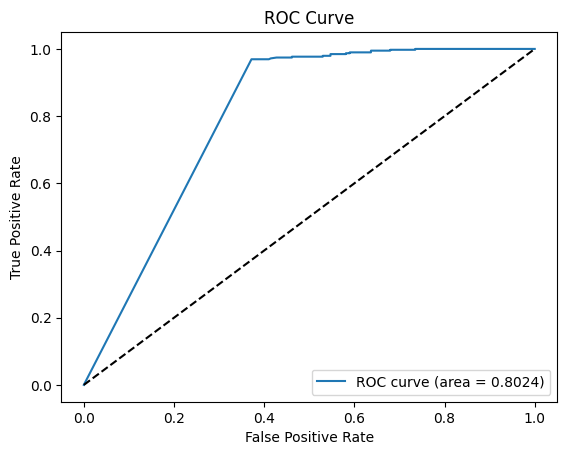

ROC-AUC Score: 0.8024


In [16]:

# Compute Precision, Recall, F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Compute ROC-AUC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

In [25]:
import matplotlib.pyplot as plt

In [26]:
def plot_loss(loss_array):
    plt.figure(figsize=(10,5))
    plt.plot(loss_test, label='Test Loss')
    plt.plot(loss_train, label='Train Loss')
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show()

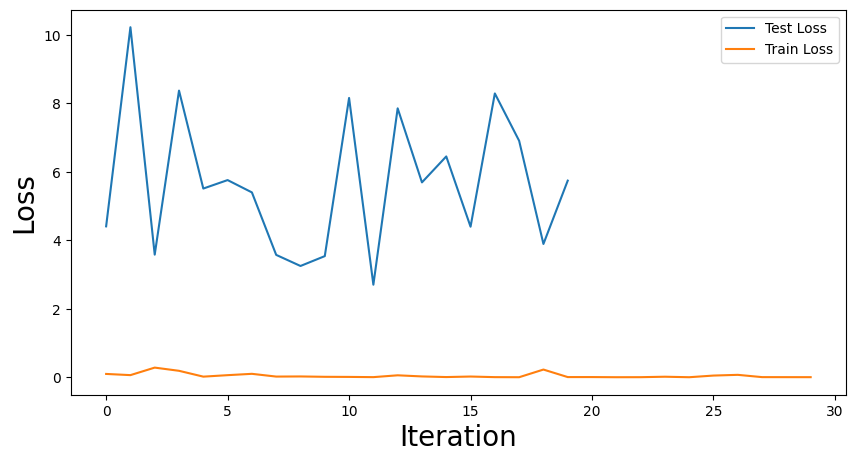

In [27]:
loss_array = []
plot_loss(loss_array)